In [1]:
import re
import string
!pip install visualkeras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
!pip install seaborn plotly
import seaborn as sns

import tensorflow as tf
!pip install transformers

import transformers
from transformers import BertTokenizer
from transformers import TFAutoModel

from tensorflow.keras.callbacks import EarlyStopping

print(tf.__version__)
print(transformers.__version__)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.0/993.0 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 33.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 33.1 MB/s eta 0:00:00
2.12.0
4.31.0


# 📋 Loading the Data

In [2]:
#@title
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
!pip install gensim nltk
import gensim
from gensim.models import Word2Vec
from nltk.tokenize import sent_tokenize, word_tokenize
import warnings
warnings.filterwarnings("ignore")
#df = pd.read_csv('/kaggle/input/uk-twitter-covid19-dataset/sample_data.csv')
#df = pd.read_csv('/kaggle/input/external-covid-19-twitter-dataset/us_airlines_sample_data.csv')
#df = pd.read_csv('/kaggle/input/appletwittersentimenttexts/apple-twitter-sentiment-texts.csv')
#df = pd.read_csv('/kaggle/input/external-covid-19-twitter-dataset/Reddit_Data.csv')
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Twitter_Data.csv')

In [4]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162980 entries, 0 to 162979
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   clean_text  162976 non-null  object 
 1   category    162973 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.5+ MB
None


In [5]:
df = df.dropna()
df.head()

,clean_text,category
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0


In [6]:
#df['text'] = df['clean_tweet']
#df['target'] = df['senti_textblob']
df['text'] = df['clean_text']
df['target'] = df['category']

In [7]:

import pandas as pd

# assuming your dataframe is named 'df'
num_samples_per_label = 5000

# group the dataframe by the label column
grouped_df = df.groupby('target')

# sample a specified number of rows from each group
sampled_df = grouped_df.apply(lambda x: x.sample(n=num_samples_per_label))

# reset the index of the resulting dataframe
sampled_df = sampled_df.reset_index(drop=True)
df = sampled_df


In [8]:
#df = df.drop(columns = ['clean_text','category'])
df

,clean_text,category,text,target
0,but lollipop must for fuftkhor modi should re...,-1.0,but lollipop must for fuftkhor modi should re...,-1.0
1,brahmin modi supporter but strongly condemn hi...,-1.0,brahmin modi supporter but strongly condemn hi...,-1.0
2,bhushan nothing wrong opposing modi because do...,-1.0,bhushan nothing wrong opposing modi because do...,-1.0
3,bharat rising day day sec sec want narendra mo...,-1.0,bharat rising day day sec sec want narendra mo...,-1.0
4,staunch modi supporter but give break there no...,-1.0,staunch modi supporter but give break there no...,-1.0
...,...,...,...,...
14995,live updates india has shot down low earth orb...,1.0,live updates india has shot down low earth orb...,1.0
14996,every one says modi due some one love and some...,1.0,every one says modi due some one love and some...,1.0
14997,person whose only claim fame study for years t...,1.0,person whose only claim fame study for years t...,1.0
14998,when you see modi jis desperation for top post...,1.0,when you see modi jis desperation for top post...,1.0


In [9]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df[['text','target']], test_size = 0.2, random_state = 42)

In [10]:
train

,text,target
9839,asked modi how will give 15l each,0.0
9680,adani project have geopolitical consequence bc...,0.0
7093,modi interview pak gave assurances after every...,0.0
11293,ram your problem that you are biased you want ...,1.0
820,average indian will vote for modi nobody votes...,-1.0
...,...,...
5191,mamata and trinamool spokie derak was abusing ...,0.0
13418,full video debate which budding modi escaped f...,1.0
5390,looks like people have given listening modiji ...,0.0
860,modi knew that creating joblessness will have ...,-1.0


In [11]:
print("train, counts of label '1': {}".format(sum(train.target == 1)))
print("train, counts of label '0': {}".format(sum(train.target == 0)))
print("train, counts of label '-1': {}\n".format(sum(train.target == -1)))
print("test, counts of label '1': {}".format(sum(test.target == 1)))
print("test, counts of label '0': {}".format(sum(test.target == 0)))
print("test, counts of label '-1': {}".format(sum(test.target == -1)))

train, counts of label '1': 4007
train, counts of label '0': 4030
train, counts of label '-1': 3963

test, counts of label '1': 993
test, counts of label '0': 970
test, counts of label '-1': 1037


In [12]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

#train = reduce_mem_usage(train)
#train = reduce_mem_usage(test)

In [13]:
'''
import pandas as pd

# assume your test data is stored in a pandas DataFrame called 'test'
# and the labels are stored in a column called 'target'

# randomly sample 1000 rows from each label
label_1 = test[test.target == 1].sample(n=1000, replace=False)
label_0 = test[test.target == 0].sample(n=1000, replace=False)
label_minus_1 = test[test.target == -1].sample(n=1000, replace=False)

# concatenate the sampled rows into one DataFrame
sampled_data = pd.concat([label_1, label_0, label_minus_1])

# shuffle the DataFrame
test = sampled_data.sample(frac=1).reset_index(drop=True)
'''

"\nimport pandas as pd\n\n# assume your test data is stored in a pandas DataFrame called 'test'\n# and the labels are stored in a column called 'target'\n\n# randomly sample 1000 rows from each label\nlabel_1 = test[test.target == 1].sample(n=1000, replace=False)\nlabel_0 = test[test.target == 0].sample(n=1000, replace=False)\nlabel_minus_1 = test[test.target == -1].sample(n=1000, replace=False)\n\n# concatenate the sampled rows into one DataFrame\nsampled_data = pd.concat([label_1, label_0, label_minus_1])\n\n# shuffle the DataFrame\ntest = sampled_data.sample(frac=1).reset_index(drop=True)\n"

In [14]:
test

,text,target
11499,‘safety security and prosperity’ narendra modi...,1.0
6475,sambit exposing modi,0.0
13167,fibre import was low since last years due modi...,1.0
862,this idiots are quoted all paki media all thei...,-1.0
5970,voting for modi but election date nagar 23rd a...,0.0
...,...,...
6216,the father whos working bsnl not getting salar...,0.0
3585,modi becomes again will last electionsall inst...,-1.0
10023,every where modi high,1.0
14044,agar aap apne saal political career kiya hua b...,1.0


In [15]:
#train2, test2 = train, test

# 🔨 Preprocessing

In [16]:
#Use regex to clean the data
def remove_url(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

def remove_punct(text):
    table = str.maketrans('', '', string.punctuation)
    return text.translate(table)
def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def decontraction(text):
    text = re.sub(r"won\'t", " will not", text)
    text = re.sub(r"won\'t've", " will not have", text)
    text = re.sub(r"can\'t", " can not", text)
    text = re.sub(r"don\'t", " do not", text)

    text = re.sub(r"can\'t've", " can not have", text)
    text = re.sub(r"ma\'am", " madam", text)
    text = re.sub(r"let\'s", " let us", text)
    text = re.sub(r"ain\'t", " am not", text)
    text = re.sub(r"shan\'t", " shall not", text)
    text = re.sub(r"sha\n't", " shall not", text)
    text = re.sub(r"o\'clock", " of the clock", text)
    text = re.sub(r"y\'all", " you all", text)

    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"n\'t've", " not have", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'d've", " would have", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'ll've", " will have", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    text = re.sub(r"\'re", " are", text)
    return text

def seperate_alphanumeric(text):
    words = text
    words = re.findall(r"[^\W\d_]+|\d+", words)
    return " ".join(words)

def cont_rep_char(text):
    tchr = text.group(0)
    if len(tchr) > 1:
        return tchr[0:2]

def unique_char(rep, text):
    substitute = re.sub(r'(\w)\1+', rep, text)
    return substitute

train['text'] = train['text'].apply(lambda x : remove_url(x))
train['text'] = train['text'].apply(lambda x : remove_punct(x))
train['text'] = train['text'].apply(lambda x : remove_emoji(x))
train['text'] = train['text'].apply(lambda x : decontraction(x))
train['text'] = train['text'].apply(lambda x : seperate_alphanumeric(x))
train['text'] = train['text'].apply(lambda x : unique_char(cont_rep_char,x))

test['text'] = test['text'].apply(lambda x : remove_url(x))
test['text'] = test['text'].apply(lambda x : remove_punct(x))
test['text'] = test['text'].apply(lambda x : remove_emoji(x))
test['text'] = test['text'].apply(lambda x : decontraction(x))
test['text'] = test['text'].apply(lambda x : seperate_alphanumeric(x))
test['text'] = test['text'].apply(lambda x : unique_char(cont_rep_char,x))

# ✂️ Tokenization

In [17]:
seq_len = 256 #max([len(text) for text in train['text']]) #256
batch_size = 16 #16
num_samples = len(train)

model_name = 'cardiffnlp/twitter-roberta-base-sentiment-latest'
tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)

train_tokens = tokenizer(
    train['text'].tolist(),
    max_length=seq_len,
    truncation=True,
    padding='max_length',
    add_special_tokens=True,
    return_tensors='np'
)

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train['target'] = le.fit_transform(train['target'])
test['target'] = le.fit_transform(test['target'])

y_train = train['target'].values
labels = np.zeros((num_samples, y_train.max() + 1))
labels[np.arange(num_samples), y_train] = 1

dataset = tf.data.Dataset.from_tensor_slices(
    (
        train_tokens['input_ids'],
        train_tokens['attention_mask'],
        labels
    )
)

def map_func(input_ids, masks, labels):
    return {
        'input_ids': input_ids,
        'attention_mask': masks
    }, labels

dataset = dataset.map(map_func)
dataset = dataset.shuffle(10000).batch(batch_size=batch_size, drop_remainder=True)

split = 0.7
size = int((train_tokens['input_ids'].shape[0] // batch_size) * split)

train_ds = dataset.take(size)
val_ds = dataset.skip(size)

In [18]:
size

525

In [19]:
labels.shape

(12000, 3)

# 🤖 Model Building

## 1 Hidden Layer

In [33]:
#'''
tf.keras.backend.clear_session()
###### MODEL 1 ####

# instantiating the model in the strategy scope creates the model on the TPU
#with tpu_strategy.scope():
model = TFAutoModel.from_pretrained(model_name)

# Two inputs
input_ids = tf.keras.layers.Input(shape=(seq_len,), name='input_ids', dtype='int32')
mask = tf.keras.layers.Input(shape=(seq_len,), name='attention_mask', dtype='int32')

# Transformer
# embeddings = model.bert(input_ids, attention_mask=mask)[1]
embeddings = model(input_ids, attention_mask=mask)[0]
embeddings = embeddings[:, 0, :]
#embeddings = tf.keras.layers.GlobalAveragePooling1D()(embeddings)

# Classifier head
x = tf.keras.layers.Dense(512, activation='relu')(embeddings)
#x = tf.keras.layers.Dropout(0.1)(x)
y = tf.keras.layers.Dense(3, activation='softmax', name='outputs')(x)

bert_model = tf.keras.Model(inputs=[input_ids, mask], outputs=y)

# freeze bert layers
# bert_model.layers[2].trainable = False

optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss = tf.keras.losses.CategoricalCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy()

bert_model.compile(optimizer=optimizer, loss=loss, metrics=[acc])

# Define early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)

# Fit the model with early stopping
history = bert_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    batch_size=batch_size,
    callbacks=[early_stop]
)

#'''

All model checkpoint layers were used when initializing TFRobertaModel.

All the layers of TFRobertaModel were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Epoch 1/50


525/525 [==============================] - 591s 980ms/step - loss: 0.6547 - categorical_accuracy: 0.7355 - val_loss: 0.4024 - val_categorical_accuracy: 0.8619
Epoch 2/50
525/525 [==============================] - 471s 898ms/step - loss: 0.3422 - categorical_accuracy: 0.8817 - val_loss: 0.1846 - val_categorical_accuracy: 0.9389
Epoch 3/50
525/525 [==============================] - 495s 943ms/step - loss: 0.2347 - categorical_accuracy: 0.9239 - val_loss: 0.1507 - val_categorical_accuracy: 0.9508
Epoch 4/50
525/525 [==============================] - 471s 897ms/step - loss: 0.1732 - categorical_accuracy: 0.9461 - val_loss: 0.0987 - val_categorical_accuracy: 0.9728
Epoch 5/50
525/525 [==============================] - 471s 896ms/step - loss: 0.1297 - categorical_accuracy: 0.9590 - val_loss: 0.0861 - val_categorical_accuracy: 0.9742
Epoch 6/50
525/525 [==============================] - 494s 942ms/step - loss: 0.1001 - categorical_accuracy: 0.9704 - val_loss: 0.0461 - val_categorical_accuracy

              precision    recall  f1-score   support

    Negative       0.93      0.92      0.92      1037
     Neutral       0.96      0.94      0.95       970
    Positive       0.91      0.94      0.92       993

    accuracy                           0.93      3000
   macro avg       0.93      0.93      0.93      3000
weighted avg       0.93      0.93      0.93      3000



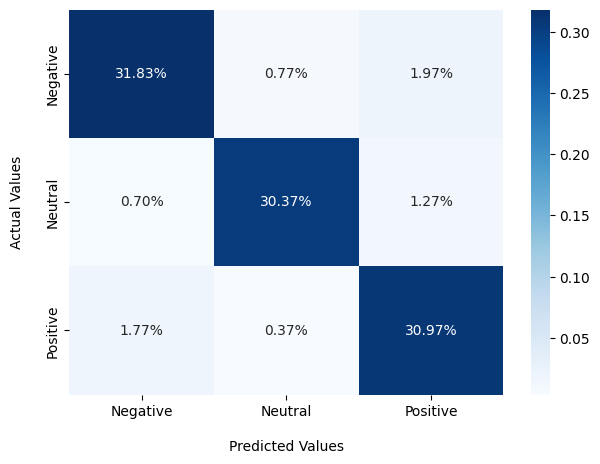

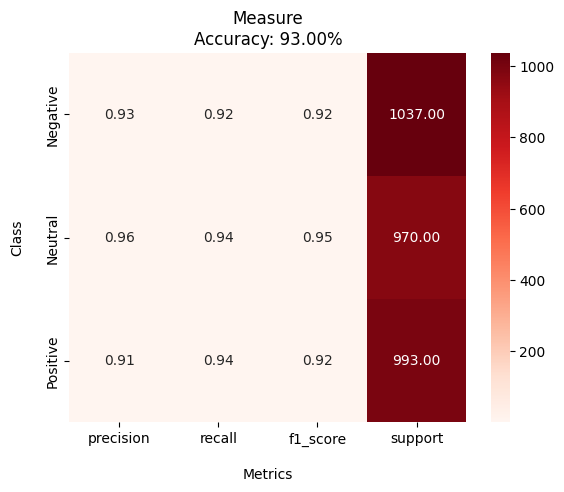

In [34]:
# For Data Visualization
import matplotlib.pyplot as plt
import matplotlib
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns

# Miscellaneous
from tqdm import tqdm
import os
import random
from IPython import display

def prep_data(text):
    tokens = tokenizer(
        text, max_length=seq_len, truncation=True,
        padding='max_length',
        add_special_tokens=True,
        return_tensors='tf'
    )
    return {
        'input_ids': tokens['input_ids'],
        'attention_mask': tokens['attention_mask']
    }

test['prediction'] = None

for i, row in test.iterrows():
    tokens = prep_data(row['text'])
    #probs = bert_model.predict(tokens)
    probs = bert_model.predict_on_batch(tokens)
    pred = np.argmax(probs)
    test.at[i, 'prediction'] = pred

test['prediction'] = test['prediction'].astype(int)

labels = ['Negative','Neutral','Positive']
from sklearn.metrics import classification_report
print(classification_report(test['target'], test['prediction'], target_names=labels))


from sklearn.metrics import *
cm = confusion_matrix(test['target'], test['prediction'])

plt.figure(figsize=(7,5))

ax = sns.heatmap(cm/np.sum(cm),fmt='.2%', annot=True, cmap='Blues')

ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values\n');

ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

plt.savefig('cm.png')
plt.show()

print()
print()
print()

from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


def plot_classification_report(report):
    report_data = []
    lines = report.split('\n')
    lines = list(filter(None, lines))
    for line in lines[1:-3]:
        row = {}
        row_data = line.split()
        row_data = list(filter(None, row_data))
        row['class'] = row_data[0]
        row['precision'] = float(row_data[1])
        row['recall'] = float(row_data[2])
        row['f1_score'] = float(row_data[3])
        row['support'] = float(row_data[4])
        report_data.append(row)
    df = pd.DataFrame.from_dict(report_data)
    df.set_index('class', inplace=True)
    heatmap = sns.heatmap(df, annot=True, cmap='Reds', fmt='.2f')
    heatmap.set_xlabel('\nMetrics')
    heatmap.set_ylabel('Class\n')
    heatmap.set_title('Classification Report')


def accuracy_score(report):
    report_data = []
    lines = report.split('\n')
    lines = list(filter(None, lines))
    for line in lines[4:-2]:
        row_data = line.split()
        row_data = list(filter(None, row_data))
        return float(row_data[1])


labels = ['Negative','Neutral','Positive']

report = classification_report(test['target'], test['prediction'], target_names=labels)
plot_classification_report(report)
accuracy = accuracy_score(report)

plt.title('Measure\nAccuracy: {:.2f}%'.format(accuracy*100))
plt.savefig('classification_reports.png')
plt.show()


In [ ]:
#!zip -r file.zip /content/model.h5